# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.250941,False,-0.656855
1,0.011862,True,5.154573
2,-1.751551,False,-3.646515
3,-2.648773,False,-2.586609
4,-2.100894,False,-4.132647
...,...,...,...
995,-0.844582,False,-2.807769
996,-2.482145,False,-5.592985
997,-1.899882,False,-3.723633
998,-2.036182,False,-5.959826


<AxesSubplot:xlabel='v0'>

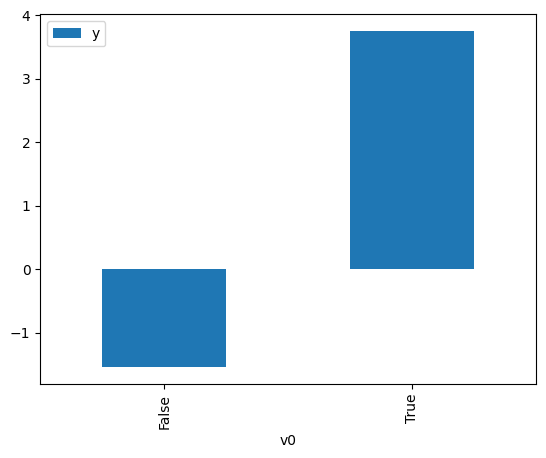

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

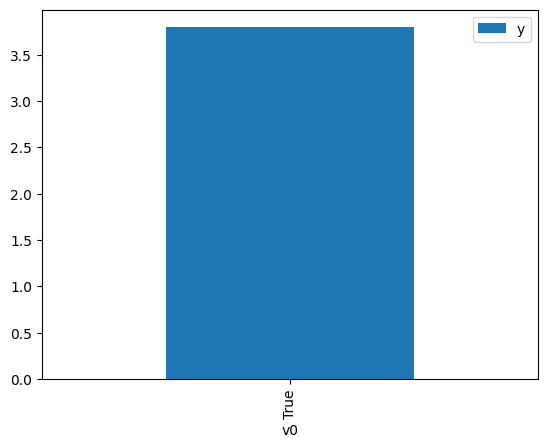

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.080916,False,-3.749920,0.839234,1.191563
1,-0.378467,False,0.053210,0.626933,1.595066
2,-2.178057,False,-3.794883,0.968411,1.032619
3,-2.369960,False,-5.629943,0.976627,1.023933
4,-1.961412,False,-3.984804,0.955777,1.046269
...,...,...,...,...,...
995,-1.691666,False,-2.406136,0.933269,1.071502
996,-1.166320,False,-2.712309,0.856969,1.166903
997,-1.201929,False,-3.659684,0.863869,1.157583
998,-0.779560,False,-1.063985,0.762471,1.311525


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.024390,True,4.091306,0.513059,1.949094
1,0.442290,True,7.042294,0.691101,1.446967
2,0.016557,True,4.243944,0.529545,1.888413
3,-0.856835,True,4.039040,0.215689,4.636297
4,-0.488011,True,4.203498,0.332735,3.005394
...,...,...,...,...,...
995,-1.565416,True,0.813885,0.080593,12.408014
996,-1.080100,True,3.805645,0.160944,6.213342
997,-0.234925,True,2.954979,0.428624,2.333045
998,0.526734,True,7.236482,0.719408,1.390031


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8070.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:24:24   Log-Likelihood:                         -1403.6
No. Observations:                1000   AIC:                                      2811.
Df Residuals:                     998   BIC:                                      2821.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1889      0.025     87.193      0.000       2.140       2.238
x2             4.9304      0.055     89.857      0.000       4.823       5.038
==============================================================================
Omnibus:                        0.133   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.085
Skew:                           0.019   Prob(JB):                        0.958
Kurtosis:                       3.023   Cond. No.                         2.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""